In [10]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.utils import make_grid
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.transforms.functional import convert_image_dtype
from pycocotools.coco import COCO

plt.rcParams["savefig.bbox"] = 'tight'

In [107]:
m = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [113]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15,15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [25]:
COCO_SPLIT = "val2017"
COCO_DIR = "../data/coco"
coco_annotations = f"{COCO_DIR}/annotations/instances_{COCO_SPLIT}.json"
coco = COCO(coco_annotations)
category_ids = coco.getCatIds(catNms = ["person"])
image_ids = coco.getImgIds(catIds = category_ids)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [94]:
def xyxy_to_xywh(boxes):
    boxes_xywh = boxes.copy()
    boxes_xywh[:, 0] = boxes[:, 0] + (boxes[:, 2] - boxes[:, 0]) / 2
    boxes_xywh[:, 1] = boxes[:, 1] + (boxes[:, 3] - boxes[:, 1]) / 2
    boxes_xywh[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes_xywh[:, 3] = boxes[:, 3] - boxes[:, 1]
    return boxes_xywh


def xywh_to_xyxy(boxes):
    boxes_xyxy = boxes.copy()
    boxes_xyxy[:, 0] = boxes[:, 0]
    boxes_xyxy[:, 1] = boxes[:, 1]
    boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3]
    return boxes_xyxy

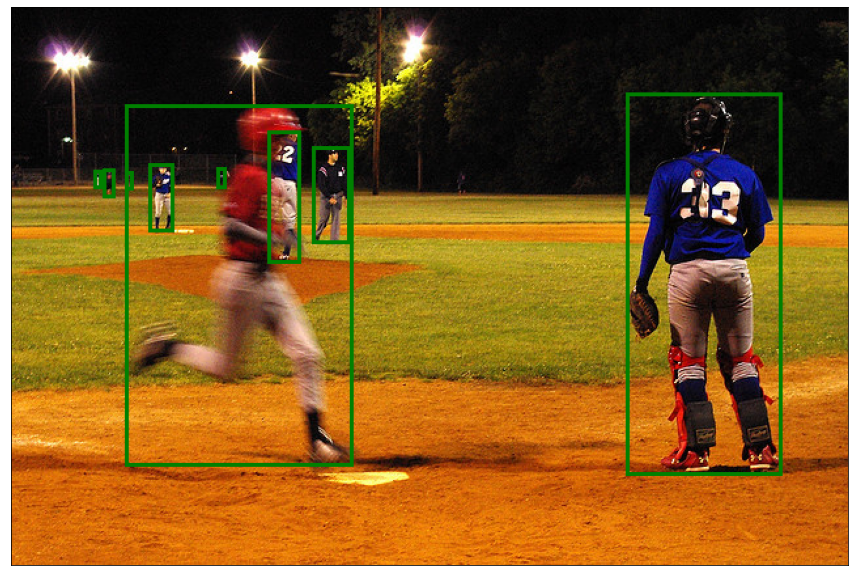

In [129]:
image = coco.loadImgs(image_ids[np.random.randint(0,len(image_ids))])[0]
image_path = f"{COCO_DIR}/images/{COCO_SPLIT}/{image['file_name']}"
test_image = read_image(image_path)

annotation_ids = coco.getAnnIds(imgIds=image["id"], catIds=category_ids, iscrowd=None)
annotations = coco.loadAnns(annotation_ids)
gt_bboxes = torch.tensor(xywh_to_xyxy(np.array([ a["bbox"] for a in annotations ])))

annotated_images = []
annotated_images.append(
    draw_bounding_boxes(
        test_image, 
        boxes=gt_bboxes,
        colors=[ "green" for i in range(len(gt_bboxes)) ],
        width=3,
    )
)

show(annotated_images)

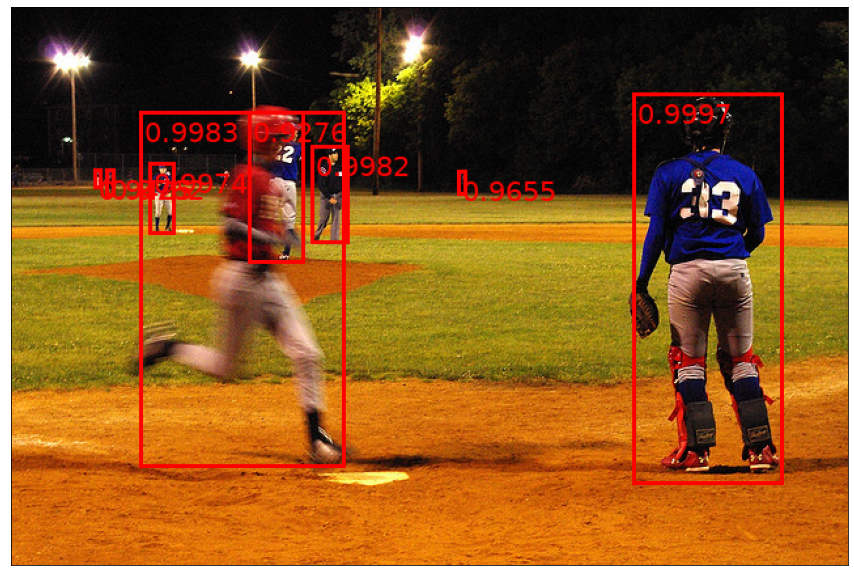

In [130]:
m.to("cuda").eval()
batch_int = torch.stack([test_image])
batch = convert_image_dtype(batch_int, dtype=torch.float)
outputs = m(batch.to("cuda"))

score_threshold = .8
persons_with_boxes = []
for image, output in zip(batch_int, outputs):
    selection = (output['scores'] > score_threshold) & (output['labels'] == 1)
    labels = output["scores"][selection].detach().cpu().numpy().round(4).astype(str)
    persons_with_boxes.append(
        draw_bounding_boxes(
            image, 
            boxes=output['boxes'][selection],
            labels=labels,
            colors=[ "red" for i in range(len(labels)) ],
            width=3,
            font_size=image.shape[1] // 20,
            font="DejaVuSans.ttf"
        )
    )
    
show(persons_with_boxes)